In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [15]:
# Définir la vitesse souhaitée (remplacez la valeur ici)
base_speed_selector = '14Kmh'  # Choisissez entre '16Kmh', '14Kmh', '12Kmh', '10Kmh'

# Dictionnaire des paramètres pour chaque vitesse
params = {
    '16Kmh': {'file_suffix': 'R16.txt', 'seuil_p': 4.55, 'seuil_v': 4.35, 'MAX_TIME_DIFF': 0.38, 'MIN_TIME_DIFF': 0.28},
    '14Kmh': {'file_suffix': 'R14.txt', 'seuil_p': 4, 'seuil_v': 3.8, 'MAX_TIME_DIFF': 0.39, 'MIN_TIME_DIFF': 0.29},
    '12Kmh': {'file_suffix': 'R12.txt', 'seuil_p': 3.39, 'seuil_v': 3.27, 'MAX_TIME_DIFF': 0.41, 'MIN_TIME_DIFF': 0.30},
    '10Kmh': {'file_suffix': 'R10.txt', 'seuil_p': 2.795, 'seuil_v': 2.755, 'MAX_TIME_DIFF': 0.45, 'MIN_TIME_DIFF': 0.29},
}

# Récupérer les paramètres en fonction de la vitesse choisie
file_path = f'D:\\Documents\\Mémoire\\Data John Doe\\John Doe gaitway 3D locomotion_{params[base_speed_selector]["file_suffix"]}'
output_file = f'D:\\Documents\\Mémoire\\Data John Doe\\Auto Python\\RAWSpeed\\ResultPython_JD_{params[base_speed_selector]["file_suffix"]}'
seuil_p = params[base_speed_selector]['seuil_p']
seuil_v = params[base_speed_selector]['seuil_v']
MAX_TIME_DIFF = params[base_speed_selector]['MAX_TIME_DIFF']
MIN_TIME_DIFF = params[base_speed_selector]['MIN_TIME_DIFF']

print(f"Paramétré pour {base_speed_selector}")

Paramétré pour 14Kmh


In [16]:
# Lire le fichier en ignorant les 43 premières lignes
data = pd.read_csv(file_path, delimiter='\t', header=None, skiprows=44)

# Extraire les colonnes nécessaires
time = data[0]
raw_speed = (1164.1/data[9])
contact_mode = data[31]

# Initialiser les listes pour stocker les vallées, les peaks et les transitions de contact mode
valleys = []
peaks = []


In [17]:
# Supprimer les spike selon 2 conditions (>4xEcartType AND EcartType>0.5) sur les 5 valeurs d'avant. Remplace par la moyenne des 5
def remove_spikes(raw_speed):
    # Créer une copie du signal
    filtered_speed = raw_speed.copy()
    
    # Parcourir chaque point du signal à partir du 6e point
    for i in range(5, len(raw_speed)):
        # Calculer la moyenne et l'écart-type des 5 valeurs précédentes
        previous_values = raw_speed[i-5:i]
        mean_previous = np.mean(previous_values)
        std_previous = np.std(previous_values)
        
        # Vérifier si la différence est un pic
        if abs(raw_speed[i] - mean_previous) > 4 * std_previous and abs(raw_speed[i] - mean_previous) > 0.5:
            # Remplacer par la moyenne des 5 valeurs précédentes
            filtered_speed[i] = mean_previous
    
    return filtered_speed

filtered_speed = remove_spikes(raw_speed)


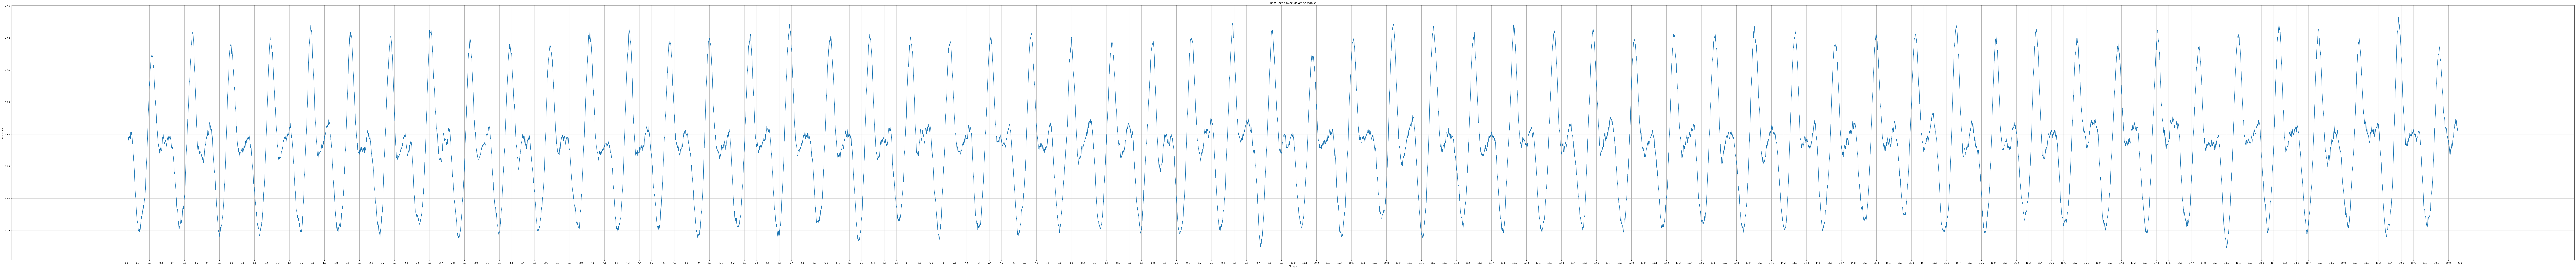

In [18]:
# Calculer la moyenne mobile
moving_average_raw_speed_1 = filtered_speed.rolling(window=35, center=True).mean()

#First graph
plt.figure(figsize=(200, 20))

plt.plot(time, moving_average_raw_speed_1, label='Moyenne mobile de Raw Speed filtrée')

plt.xticks(np.arange(min(time), max(time) + 0.1, 0.1))
plt.grid()
plt.xlabel('Temps')
plt.ylabel('Raw Speed')
plt.title('Raw Speed avec Moyenne Mobile')
plt.show()


In [19]:
# # Détecter les vallées et les peaks
# for i in range(10, len(moving_average_raw_speed_1) - 10):
#     if pd.notna(moving_average_raw_speed_1[i]):  # Vérifier que la valeur n'est pas NaN
#         window = moving_average_raw_speed_1[i - 10:i + 11]
#         min_value = window.min()
#         max_value = window.max()
# 
#         is_vallee = moving_average_raw_speed_1[i] == min_value and moving_average_raw_speed_1[i] < seuil_v
#         is_pic = moving_average_raw_speed_1[i] == max_value and moving_average_raw_speed_1[i] > seuil_p
# 
#     if is_vallee:
#         valleys.append((time[i], moving_average_raw_speed_1[i], 'Vallee'))
#     if is_pic:
#         peaks.append((time[i], moving_average_raw_speed_1[i], 'Pic'))


In [20]:
# Pose et levé de pied
lift_down = []
lift_off = []

previous_mode = None
for i in range(len(contact_mode)):
    if pd.notna(contact_mode[i]):
        current_mode = contact_mode[i]
        if (previous_mode is None or previous_mode != 'SC') and current_mode == 'SC':
            lift_down.append((time[i], 'Pose de Pied'))
        if (previous_mode is None or previous_mode != 'Aerial') and current_mode == 'Aerial':
            lift_off.append((time[i], 'Levé de Pied'))
        previous_mode = current_mode
            

In [21]:
# Créer des DataFrames pour les vallées, les peaks et les transitions
df_valleys = pd.DataFrame(valleys, columns=['Time', 'Speed', 'Type'])
df_peaks = pd.DataFrame(peaks, columns=['Time', 'Speed', 'Type'])
lift_down_df = pd.DataFrame(lift_down, columns=['Time', 'Type'])
lift_off_df = pd.DataFrame(lift_off, columns=['Time', 'Type'])

# Calculer la différence de temps entre chaque valeur x+1 et x.
df_valleys['Time difference'] = df_valleys['Time'].diff().shift(-1).abs()
df_peaks['Time difference'] = df_peaks['Time'].diff().shift(-1).abs()
lift_down_df['Time difference'] = lift_down_df['Time'].diff().shift(-1).abs()
lift_off_df['Time difference'] = lift_off_df['Time'].diff().shift(-1).abs()

# Arrondir les valeurs de vitesse et de différence de temps
df_valleys['Speed'] = df_valleys['Speed'].round(5)
df_peaks['Speed'] = df_peaks['Speed'].round(5)
df_valleys['Time difference'] = df_valleys['Time difference'].round(4)
df_peaks['Time difference'] = df_peaks['Time difference'].round(4)
lift_down_df['Time difference'] = lift_down_df['Time difference'].round(4)
lift_off_df['Time difference'] = lift_off_df['Time difference'].round(4)


In [22]:
def check_values(df):
    if not df.empty:
        errors = []
        df['Errors'] = [None] * len(df['Time difference'])
        # Vérifier les différences de temps pour les valeurs
        for index, row in df.iterrows():
            if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
                df.loc[index, "Errors"] = "ERR"
                errors.append(index)

        if len(errors) > 0:
            msg = ', '.join(map(str, errors))
            print(f"{len(errors)} Erreurs sur les index {msg}\n")

# Vérifier les erreurs
if valleys is not None and peaks is not None and lift_down is not None and lift_off is not None:
    print(('si vide = pas derreur'))
    print("Valleys :")
    check_values(df_valleys)
    print("Peaks :")
    check_values(df_peaks)
    print("Pose de pied :")
    check_values(lift_down_df)
    print("Levé de pied :")
    check_values(lift_off_df)
    

si vide = pas derreur
Valleys :
Peaks :
Pose de pied :
Levé de pied :


In [23]:
# def write_results_to_file(valleys, peaks, lift_down, lift_off, output_file):
#     with open(output_file, 'w') as f:
#         f.write("Vallées détectées:\t")
#         if not valleys.empty:
#             f.write(f"({len(valleys)})\n")
#             valleys.to_csv(f, index=False, sep='\t', lineterminator="\n")
#             # Vérifier les différences de temps pour les vallées
#             for index, row in valleys.iterrows():
#                 if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
#                     f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les vallées\n")
#         else:
#             f.write("Aucune vallée détectée.\n")
# 
# 
#         f.write("\nPics détectés:\t")
#         if not peaks.empty:
#             f.write(f"({len(peaks)})\n")
#             peaks.to_csv(f, index=False, sep='\t', lineterminator="\n")
#             # Vérifier les différences de temps pour les peaks
#             for index, row in peaks.iterrows():
#                 if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
#                     f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les peaks\n")
#         else:
#             f.write("Aucun pic détecté.\n")
# 
# 
#         f.write("\nPied posé dans contact_mode :\t")
#         if not lift_down.empty:
#             f.write(f"({len(lift_down)})\n")
#             lift_down.to_csv(f, index=False, sep='\t', lineterminator="\n")
#             # Vérifier les différences de temps pour les transitions
#             for index, row in lift_down.iterrows():
#                 if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
#                     f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les Pose de pied\n")
#         else:
#             f.write("Aucune pose de pied détectée.\n")
# 
# 
#         f.write("\nPied levé dans contact_mode :\t")
#         if not lift_off.empty:
#             f.write(f"({len(lift_off)})\n")
#             lift_off.to_csv(f, index=False, sep='\t', lineterminator="\n")
#             # Vérifier les différences de temps pour les transitions
#             for index, row in lift_off.iterrows():
#                 if row['Time difference'] > MAX_TIME_DIFF or row['Time difference'] < MIN_TIME_DIFF:
#                     f.write(f"Erreur: Différence de temps {row['Time difference']} ms à l'index {index} pour les Pose de pied\n")
#         else:
#             f.write("Aucune pose de pied détectée.\n")
# 
# def write_results_to_excel(valleys, peaks, lift_off, lift_down, output_file):
#     # Create a Pandas Excel writer using XlsxWriter as the engine
#     with pd.ExcelWriter(output_file) as writer:
#         # Write each dataframe to a different worksheet
#         valleys.to_excel(writer, sheet_name='Vallées', index=False)
#         peaks.to_excel(writer, sheet_name='Pics', index=False)
#         lift_off.to_excel(writer, sheet_name='Levé de pied', index=False)
#         lift_down.to_excel(writer, sheet_name='Pose de pied', index=False)
# 
#     print(f"Le tableau excel à bien été crée dans  {output_file}")
# 
# if valleys is not None and peaks is not None and lift_down is not None and lift_off is not None :
#     write_results_to_file( df_valleys, df_peaks, lift_down_df, lift_off_df, output_file)
#     write_results_to_excel(df_valleys, df_peaks, lift_down_df, lift_off_df, output_file.replace(".txt", ".xlsx"))
#     print(f"Le fichier txt a été crée dans : {output_file}")

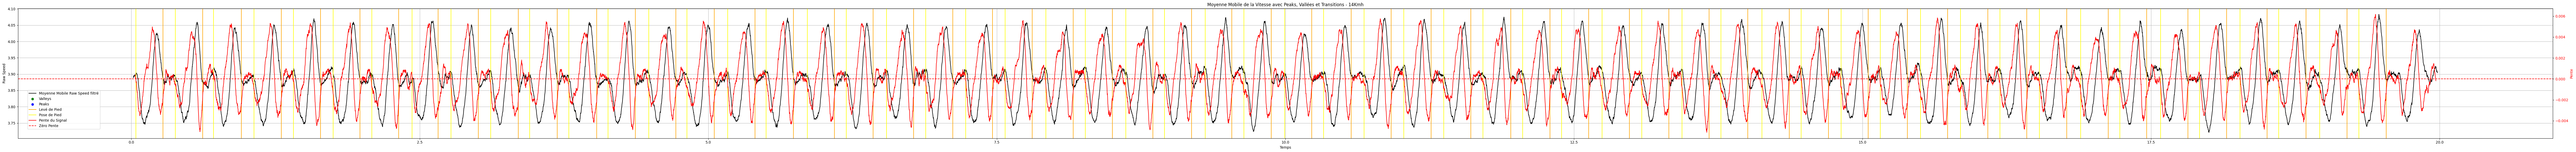

In [24]:
# Calculer la pente du signal (dérivée discrète)
slope = moving_average_raw_speed_1.diff()
filtered_slope = slope.rolling(window=30, center=True).mean()

fig, ax1 = plt.subplots(figsize=(100, 6))

# Tracé de la moyenne mobile
ax1.plot(time, moving_average_raw_speed_1, color="black", label="Moyenne Mobile Raw Speed filtré")
ax1.set_xlabel('Temps')
ax1.set_ylabel('Raw Speed', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Ajout des peaks et vallées
ax1.scatter(df_valleys['Time'], df_valleys['Speed'], color='green', label='Valleys')
ax1.scatter(df_peaks['Time'], df_peaks['Speed'], color='blue', label='Peaks')

# Créer un deuxième axe y pour la pente
ax2 = ax1.twinx()
ax2.set_ylabel('Pente', color='red')
ax2.plot(time, filtered_slope, color='red', label='Pente du Signal')
ax2.tick_params(axis='y', labelcolor='red')

ax2.axhline(y=0, color='red', linestyle='dashed', label='Zéro Pente')



# Tracer les barres verticales pour lift_off et lift_down
for i, row in lift_off_df.iterrows():
    ax1.axvline(x=row['Time'], color='orange', label='Levé de Pied' if i == 0 else "")
for i, row in lift_down_df.iterrows():
    ax1.axvline(x=row['Time'], color='yellow', label='Pose de Pied' if i == 0 else "")

plt.title(f'Moyenne Mobile de la Vitesse avec Peaks, Vallées et Transitions - {base_speed_selector}')
ax1.grid(True)
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.04, 0.42))
plt.show()


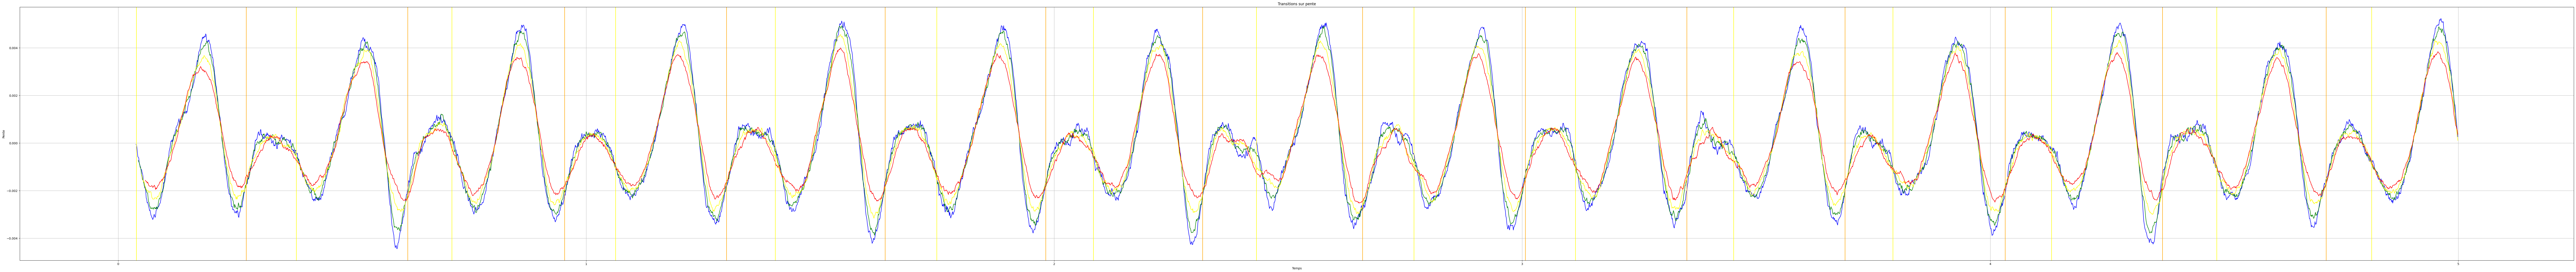

In [25]:
slope = moving_average_raw_speed_1.diff()
filtered_slope_1 = slope.rolling(window=40, center=True).mean()
filtered_slope_2 = slope.rolling(window=50, center=True).mean()
filtered_slope_3 = slope.rolling(window=65, center=True).mean()
filtered_slope_4 = slope.rolling(window=80, center=True).mean()

plt.figure(figsize=(150, 15))

plt.plot(time[:5000], filtered_slope_1[:5000], color='blue', label='Pente du Signal')
plt.plot(time[:5000], filtered_slope_2[:5000], color='green', label='Pente du Signal')
plt.plot(time[:5000], filtered_slope_3[:5000], color='yellow', label='Pente du Signal')
plt.plot(time[:5000], filtered_slope_4[:5000], color='red', label='Pente du Signal')

# Tracer les barres verticales pour lift_off et lift_down

for i, row in lift_off_df.iterrows():
    if row['Time'] <= time[5000]:
       plt.axvline(x=row['Time'], color='orange', label='Levé de Pied' if i == 0 else "")
for i, row in lift_down_df.iterrows():
    if row['Time'] <= time[5000]:
      plt.axvline(x=row['Time'], color='yellow', label='Pose de Pied' if i == 0 else "")
    
plt.xlabel('Temps')
plt.ylabel('Pente')
plt.title('Transitions sur pente')
plt.grid(True)
plt.show()


In [26]:
# # Écrire les 5000 premières valeurs de filtered_slope_2 et leur temps associé dans output_file
# output_data = pd.DataFrame({
#     'Time': time[:5000],
#     'Filtered_Slope_2': filtered_slope_2[:5000]
# })
# 
# output_data.to_csv(output_file, index=False, sep='\t')